In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import express as px

import ast
import pickle
from tqdm import tqdm

import networkx as nx
import random
import json

from collections import Counter

## Load in Data

### Load in Tweet Data

In [2]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')

In [3]:
# evaluating strings of lists as lists
df['hashtags'] = df['hashtags'].apply(ast.literal_eval)
df['mentions'] = df['mentions'].apply(ast.literal_eval)
# df['keywords'] = df['keywords'].apply(ast.literal_eval)

In [4]:
df.columns[:35]

Index(['created_at', 'tweet_id', 'text', 'in_reply_to_tweet_id',
       'in_reply_to_user_id', 'geo', 'quote_count', 'reply_count',
       'retweet_count', 'favorite_count', 'lang', 'quoted_tweet_id',
       'possibly_sensitive', 'user_id', 'screen_name', 'followers_count',
       'friends_count', 'statuses_count', 'verified', 'hashtags', 'mentions',
       'date', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12'],
      dtype='object')

### Load in Crime Data

Load in the hate crime `hatecrimedata.csv` dataframe.

In [5]:
df_crime = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/hatecrimedata.csv')

In [6]:
# limiting to only dates that have associated tweets
df_crime['incident_date'] = pd.to_datetime(df_crime['incident_date'])
start_date = pd.to_datetime('2020-03-11')
end_date = pd.to_datetime('2021-06-17')

df_crime = df_crime[(df_crime['incident_date'] >= start_date) & (df_crime['incident_date'] <= end_date)]
df_crime['incident_date'] = pd.to_datetime(df_crime['incident_date']).dt.strftime('%Y-%m-%d')

In [7]:
df_crime = df_crime[df_crime['state_name'] == 'California']

In [8]:
df_crime.columns

Index(['incident_id', 'data_year', 'ori', 'pug_agency_name', 'pub_agency_unit',
       'agency_type_name', 'state_abbr', 'state_name', 'division_name',
       'region_name', 'population_group_code', 'population_group_description',
       'incident_date', 'adult_victim_count', 'juvenile_victim_count',
       'total_offender_count', 'adult_offender_count',
       'juvenile_offender_count', 'offender_race', 'offender_ethnicity',
       'victim_count', 'offense_name', 'total_individual_victims',
       'location_name', 'bias_desc', 'victim_types', 'multiple_offense',
       'multiple_bias'],
      dtype='object')

### Load in Topic Data

In [9]:
doc_info = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/topics/bigbaby_r_30_docs.csv')
top_info = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/topics/bigbaby_r_30_tops.csv')

In [10]:
top_info['Representation'] = top_info['Representation'].apply(ast.literal_eval)

In [11]:
top_info.columns

Index(['Topic', 'Count', 'Name', 'Representation', 'Representative_Docs'], dtype='object')

In [12]:
top2name = top_info.set_index('Topic')['Name'].to_dict()

### Querying by a Given Group

Only black-related topics:

In [13]:
top_list = [1,2,3,4,7,8,9,11,13,15,19,20,21,23,25,27,31,34,36,38,40,41,42,44,45,46,47,48,50,
            51,52,56,62,63,64,66,68,70,71,73,75,76,78,82,83,84,86,88,92,93,94,101,102,105,106,
            107,109,111,114,117,119,120, 121,122,123,124,125,126,131,132,133,137,140,143,144,145,
            146,147,149,150,151,153,154,155,157,160,162,163,164,165,166,168,169,171,172,177,178,179,
            180,184,186,187,188,191,193,196,200,202,203,206,208,211,212,216,218,220,222,223,224,225,
            226,228,229,230,233,235,242,244,245,250,251,253,254,255,256,259,260,261,266,268,269]
# black_topics = [1,2,3,4,7,8,9,11,13,15,19,20,21,23,25,27,31,34,36,38,40,41,42,44,45,46,47,48,50,
# 51,52,56,62,63,64,66,68,70,71,73,75,76,78,82,83,84,86,88,92,93,94,101,102,105,106,
# 107,109,111,114,117,119,120, 121,122,123,124,125,126,131,132,133,137,140,143,144,145,
# 146,147,149,150,151,153,154,155,157,160,162,163,164,165,166,168,169,171,172,177,178,179,
# 180,184,186,187,188,191,193,196,200,202,203,206,208,211,212,216,218,220,222,223,224,225,
# 226,228,229,230,233,235,242,244,245,250,251,253,254,255,256,259,260,261,266,268,269]
# lgbt_topics = [28,26,58,175,57,209,22,53,168,180,18,156,182,104,215,247]
# jewish_topics = [79,24,72,0,30,37,55,87,91,129,121,129,199,205,264,10,59,5,6,100,262]
# asian_topics = [67,69,96,115,135,147,161,16,99,183,195,201,221,243,101]
# hispanic_topics = [32,35,65,135,142]

Only tweets that have at least 0.01 probability of being in one of the above topics:

In [14]:
df = df[df[[str(num) for num in top_list]].ge(0.01).any(axis=1)]

Only black crimes:

In [15]:
df_crime = df_crime[df_crime['bias_desc'].str.contains('Black')]

## Building the KG

In [16]:
# turns the dataframes into lists of dictionaries
tweet_dict = df.to_dict(orient='records')
crime_dict = df_crime.to_dict(orient='records')

### Getting unique entities, hashtags, topics

In [17]:
entities = set()

for tweet in tqdm(tweet_dict):
    entities.add((tweet['tweet_id'], 't'))
    # consider adding to tweet: sentiment, quote_count, reply_count, retweet_count, favorite_count, lang, possibly_sensitive
    # consider adding to user: followers_count, friends_count, statuses_count, verified
        
for crime in crime_dict:
    entities.add((crime['incident_id'], 'c')) 
    
for top in top_list:
    entities.add(top2name[top])

100%|█████████████████████████████████| 46571/46571 [00:00<00:00, 328399.37it/s]


In [18]:
print(len(entities))

47117


In [19]:
ent_list = list(entities)
entity2id = {k:v for v,k in enumerate(ent_list)}
id2entity = {v:k for v,k in enumerate(ent_list)}

### Creating relation dictionaries

In [21]:
relations = ['tweet2topic', 'topic2group', 'group2crime']

relation2id = {}
id2relation = {}
j = 0 
for r in relations:
    relation2id[r] = j
    id2relation[j] = r
    j += 1

In [22]:
all_relations = []

## Tweet Node

### Exploring followers_count

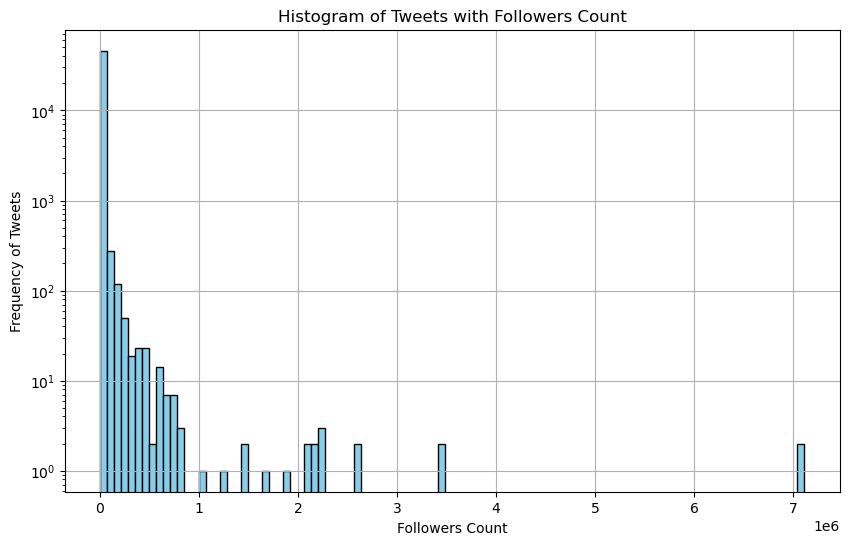

In [25]:
followers_count = df['followers_count']

# Plot the histogram with a log scale on the x-axis
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.hist(followers_count, bins=100, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Followers Count')
plt.ylabel('Frequency of Tweets')
plt.yscale('log')
plt.title('Histogram of Tweets with Followers Count')
plt.grid(True)
plt.show()

In [125]:
all_replied_users = df.dropna(subset='in_reply_to_user_id')['in_reply_to_user_id'].tolist()

In [126]:
len(all_replied_users), len(set(all_replied_users))

(12202, 8729)

Number of users replied to in our dataset (not counting multiplicity, e.g., if a given user in our dataset was replied to multiple times, this would become multiple triples, but here we are just counting how many unique users that were replied to that are among the unique users in our dataset)

In [130]:
len(set(df['user_id']).intersection(set(all_replied_users)))

1249

Number of users replied to in our dataset, counting multiplicity (this is the number of relations added to the KG)

In [156]:
# Count the multiplicity of each user in the list
user_counts = Counter(all_replied_users)

# Find the intersection of the list and set of users
intersection_users = set(all_replied_users) & set(df['user_id'])

# Count the multiplicity for each user in the intersection
intersection_counts = {user: user_counts[user] for user in intersection_users}

print(sum(intersection_counts.values()))

1991


Number of tweets that were replied to

In [127]:
all_replied_tweets=df.dropna(subset='in_reply_to_tweet_id')['in_reply_to_tweet_id'].tolist()

In [128]:
len(all_replied_tweets), len(set(all_replied_tweets))

(11226, 10976)

Number of tweets replied to in our dataset (not counting multiplicity, e.g., if a given tweet in our dataset was replied to multiple times, this would become multiple triples, but here we are just counting how many unique tweets that were replied to that are among the unique tweets in our dataset)

In [129]:
len(set(df['tweet_id']).intersection(set(all_replied_tweets)))

212

In [157]:
# Count the multiplicity of each user in the list
user_counts = Counter(all_replied_tweets)

# Find the intersection of the list and set of users
intersection_users = set(all_replied_tweets) & set(df['tweet_id'])

# Count the multiplicity for each user in the intersection
intersection_counts = {user: user_counts[user] for user in intersection_users}

print(sum(intersection_counts.values()))

215


Number of tweets that were quoted

In [132]:
all_quoted_tweets = df.dropna(subset='quoted_tweet_id')['quoted_tweet_id'].tolist()

In [133]:
len(all_quoted_tweets), len(set(all_quoted_tweets))

(8984, 8178)

Number of tweets quoted in our dataset

In [134]:
len(set(df['tweet_id']).intersection(set(all_quoted_tweets)))

47

In [158]:
# Count the multiplicity of each user in the list
user_counts = Counter(all_quoted_tweets)

# Find the intersection of the list and set of users
intersection_users = set(all_quoted_tweets) & set(df['tweet_id'])

# Count the multiplicity for each user in the intersection
intersection_counts = {user: user_counts[user] for user in intersection_users}

print(sum(intersection_counts.values()))

50


Number of users that were mentioned (counting multiplicity)

In [136]:
all_mentions = df[df["mentions"].apply(lambda x: len(x) > 0)]['mentions'].explode().tolist()

In [137]:
len(all_mentions), len(set(all_mentions))

(23195, 13011)

Number of mentioned users in our dataset

In [138]:
len(set(df['user_id']).intersection(set(all_mentions)))

226

In [159]:
# Count the multiplicity of each user in the list
user_counts = Counter(all_mentions)

# Find the intersection of the list and set of users
intersection_users = set(all_mentions) & set(df['user_id'])

# Count the multiplicity for each user in the intersection
intersection_counts = {user: user_counts[user] for user in intersection_users}

print(sum(intersection_counts.values()))

461


**From the analysis above, we will proceed by creating only triples between tweets that reply to users and tweets that mention users.**

## Tweet to Topic Edge

In [199]:
metrics = []
for tweet in tweet_dict:
    probs = []
    sents = []
    for top in top_list:
        if tweet[f'{top}'] >= 0.01:
            probs.append(tweet[f'{top}'])
            sents.append(mean_sents[top])

    probs = np.array(probs)
    sents = np.array(sents)
    metrics.append((np.sum(probs * sents)))# * tweet['followers_count'])

# metrics = 1/(1+np.exp(metrics))

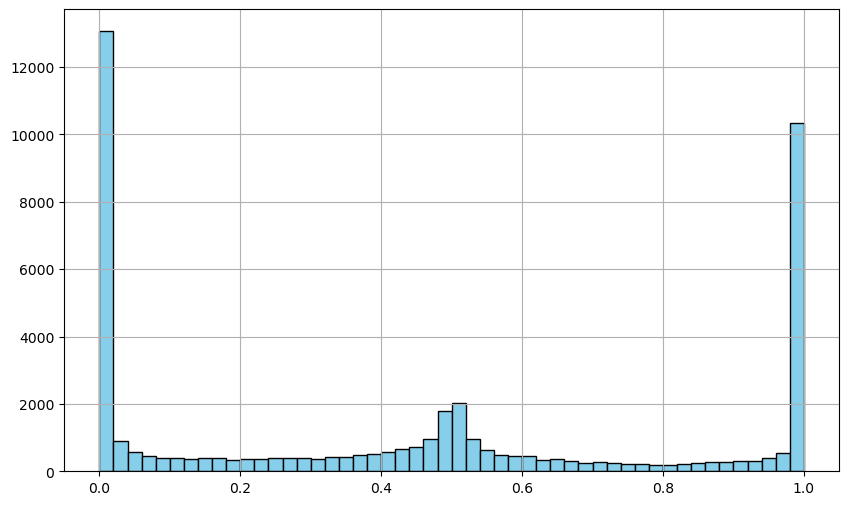

In [196]:
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.hist(metrics, bins=50, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.grid(True)
# plt.yscale('log')
plt.show()

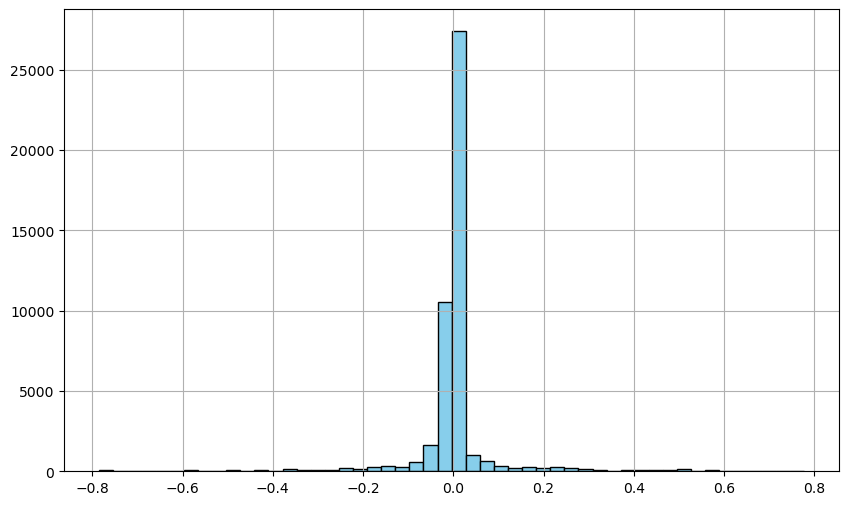

In [168]:
metrics = []
for tweet in tweet_dict:
    probs = []
    sents = []
    for top in top_list:
        if tweet[f'{top}'] >= 0.01:
            probs.append(tweet[f'{top}'])
            sents.append(mean_sents[top])

    probs = np.array(probs)
    sents = np.array(sents)
    metrics.append(np.min(probs * sents))
    
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.hist(metrics, bins=50, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.grid(True)
# plt.yscale('log')
plt.show()

In [207]:
tweet = tweet_dict[10]
for top in top_list:
    if tweet[f'{top}'] >= 0.01:
        print(tweet[f'{top}'], mean_sents[top], top2name[top])
        # probs.append(tweet[f'{top}'])
        # sents.append(mean_sents[top])

0.0325179055140092 -0.3254626666666667 13_racism_racist_anti black_anti
0.0195308657306775 0.036982894736842103 21_negro_negros_this negro_the negro
0.0105287905431751 0.08096548672566373 106_quote_we_blacklivesmatter quote_negro
0.0135274102609686 -0.2552979591836735 117_he_his_racist_anti black
0.0140998485348992 -0.045492391304347825 126_white_white people_mean anti white_anti white blm
0.012696311739625 -0.43259756097560975 225_nigger_white_white nigger_white niggers
0.0242851619219818 0.394865 229_blackwomen_blackexcellence_blackpower_blackgirls


In [201]:
for i in np.argsort(metrics)[1000:1200]:
    print(metrics[i], i, tweet_dict[i]['sent'], tweet_dict[i]['text'], '\n')

-0.2602057665943206 26741 -0.4404 @washingtonpost read the transcripts from the george floyd killing, then try to ask for our sympathy. 

-0.25936736700055235 45082 -0.93 @amazinghemi @extremelybi01 @politics_polls you are racist if you think blm is a terrorist group. the terrorists in… https://t.co/synidux3ep 

-0.2592235017869673 29657 -0.6908 @hollandcourtney blm a bunch terrorist 

-0.258601380042496 34465 -0.7906 the murder of breonna taylor was a glaring symptom of the systemic racism which plagues the united states.  may her… https://t.co/sdpwfrpuzt 

-0.2585759280910371 35185 -0.3612 today is thursday, october 1st. 6 months and 18 days since breonnataylor was murdered. 

today’s a good day to do… https://t.co/g7v8ed2hvu 

-0.2584637250142332 34239 0.2023 so the officers have a right to protect themselves but breonna taylor and her boyfriend didn’t have the right to pr… https://t.co/v7p9qfu9oy 

-0.2578443244341708 1884 0.0 breonna taylor sayhername

was in her own home when off

In [192]:
metrics = []
for tweet in tweet_dict:
    metrics.append(tweet['sent'] * tweet['followers_count'])

In [194]:
for i in np.argsort(metrics)[:100]:
    print(metrics[i], i, tweet_dict[i]['text'], '\n')

-1878788.8642 24512 i spent a day with black lives matter protesters —

diana fights for her brother daniel hernandez, who was killed b… https://t.co/0a4mh7jmsi 

-1499443.6871000002 23339 happy fathers day!!!! also, the men who killed breonna taylor still haven’t been arrested. 

-1476245.214 4140 a black man, georgefloyd is killed after pleading for his life from a police officer in minneapolis. the city erup… https://t.co/uztvpibb90 

-900239.4815999999 2453 stop calling it a “death”. george floyd didn’t just die. he was asphyxiated. a police officer held him down with hi… https://t.co/fddhpubzfa 

-567958.1632 43009 https://t.co/4gwypd9s2a stop asian hate 

-528727.1658 33916 is the things i own. 
i want to personally fight for brown girls to have more ownership and not just be a slave to… https://t.co/ilokfmghjg 

-456317.29000000004 43460 when i watched the killing of george floyd i felt sick and sad, so sad. until i realized i just witnessed the death… https://t.co/r69uprqeyi 



In [45]:
tweet_topic_relations = []

for tweet in tqdm(tweet_dict):
    for top in top_list:
        if tweet[f'{top}'] >= 0.01:
            
            relation = []
            relation.append(entity2id[(tweet['tweet_id'], 't')])
            relation.append(entity2id[top2name[top]])
            relation.append(relation2id['in_topic'])
            relation.append(tweet[f'{top}'])
            
            tweet_topic_relations.append(relation)

all_relations = [*all_relations, *tweet_topic_relations]

100%|██████████████████████████████████| 46571/46571 [00:01<00:00, 37470.56it/s]


In [46]:
len(all_relations)

181729

## Topic Node

In [45]:
mean_sents = df.groupby('topics')['sent'].mean().reset_index()
mean_sents = mean_sents.groupby('topics')['sent'].first().to_dict()

In [211]:
df2 = df.sample(n=5000)

In [212]:
df2.to_csv('sample.csv', index=False)

In [213]:
mean_sents

{-1: -0.03882251830512544,
 0: -0.06413855755894592,
 1: 0.04231398135818908,
 2: 0.020721279654924516,
 3: -0.16811972049689441,
 4: -0.22826187961985214,
 5: 0.009419831223628692,
 6: 0.11968666666666668,
 7: 0.02498124238733252,
 8: 0.5622661016949153,
 9: 0.06219897435897436,
 11: -0.1311759941089838,
 12: 0.16808045977011493,
 13: -0.3254626666666667,
 15: 0.0018508992805755394,
 18: -0.06213333333333334,
 19: 0.024890203327171904,
 20: -0.19523866666666667,
 21: 0.036982894736842103,
 23: 0.08022602459016394,
 25: -0.5717568445475638,
 26: -0.4820834196891192,
 27: 0.1332798525798526,
 28: 0.11710424028268553,
 30: 0.06911333333333333,
 31: 0.5689339285714285,
 33: -0.05235882352941176,
 34: -0.4590514018691589,
 36: -0.7845,
 38: -0.4104597269624573,
 40: 0.05644775086505191,
 41: -0.17800104895104893,
 42: 0.24076405693950179,
 43: 0.13083684210526317,
 44: -0.07880221402214022,
 45: 0.04745291828793774,
 46: 0.24406091954022988,
 47: 0.04624453125,
 48: 0.10355844748858448,
 5

In [217]:
df[df['topics'] == 36]['text']

25606      arrest the cops who killed breonnataylor
25653    arrest the cops who killed \nbreonnataylor
25657      arrest the cops who killed breonnataylor
25667      arrest the cops who killed breonnataylor
25670      arrest the cops who killed breonnataylor
                            ...                    
32959      arrest the cops who killed breonnataylor
33190      arrest the cops who killed breonnataylor
33326      arrest the cops who killed breonnataylor
33469      arrest the cops who killed breonnataylor
34680      arrest the cops who killed breonnataylor
Name: text, Length: 276, dtype: object

In [43]:
tweet_date_relations = []

for tweet in tqdm(tweet_dict):
        
    relation = []
    relation.append(entity2id[(tweet['tweet_id'], 't')])
    relation.append(entity2id[tweet['date']])
    relation.append(relation2id['tweeted_on'])
    # relation.append(1.0)
        
    tweet_date_relations.append(relation)

all_relations = [*all_relations, *tweet_date_relations]

100%|█████████████████████████████████| 46571/46571 [00:00<00:00, 558734.24it/s]


In [44]:
len(all_relations)

49023

## Saving

In [49]:
len(all_relations)

228300

In [50]:
all_relations2 = []

In [51]:
for trip in tqdm(all_relations):
    relation = []
    if isinstance(id2entity[trip[0]], tuple):
        relation.append((int(id2entity[trip[0]][0]), id2entity[trip[0]][1]))
    else:    
        relation.append(id2entity[trip[0]])
    
    if isinstance(id2entity[trip[1]], tuple):
        relation.append((int(id2entity[trip[1]][0]), id2entity[trip[1]][1]))
    else:
        relation.append(id2entity[trip[1]])
    relation.append(id2relation[trip[2]])
    try:
        relation.append(trip[3])
    except:
        relation.append(np.nan)
    
    all_relations2.append(relation)

100%|███████████████████████████████| 228300/228300 [00:00<00:00, 403580.11it/s]


In [52]:
all_relations_df = pd.DataFrame(all_relations2, columns=['head', 'tail', 'relation', 'weight'])

In [53]:
all_relations_df

,head,tail,relation,weight
0,"(1237876074970636288, t)","(2251240369, u)",replied_to,NaN
1,"(1237970493170274304, t)","(756682591994916864, u)",replied_to,NaN
2,"(1237978875977588736, t)","(135319858, u)",replied_to,NaN
3,"(1238628359921270784, t)","(363269363, u)",replied_to,NaN
4,"(1239082835232690176, t)","(13753532, u)",replied_to,NaN
...,...,...,...,...
228295,"(4499019023, u)","(1405364891972603904, t)",tweeted,NaN
228296,"(364412285, u)","(1405370661778825216, t)",tweeted,NaN
228297,"(4499019023, u)","(1405374487667695616, t)",tweeted,NaN
228298,"(2381476945, u)","(1405382223663009792, t)",tweeted,NaN


In [55]:
all_relations_df.to_csv('./data/kg_black_3.csv', index=False)